# Tic-Tac-Toe

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
np.random.seed(228)

In [2]:
def checkPosition(position):
        if checkVertical(position, 'x') or checkHorizontal(position, 'x') \
        or checkDiagonal(position, 'x'):
            return 'w'
        elif checkVertical(position, 'o') or checkHorizontal(position, 'o') \
        or checkDiagonal(position, 'o'):
            return 'l'
        elif position.find('.') == -1:
            return 'd'
        else:
            return 'n'       

def checkVertical(position, c):
    for i in range(3, 6):
        if position[i-3] == c and position[i] == c and position[i+3] == c:
            return True
    return False

def checkHorizontal(position, c):
    for i in range(1, 8, 3):
        if position[i-1] == c and position[i] == c and position[i+1] == c:
            return True
    return False

def checkDiagonal(position, c):
    if (position[0] == c and position[4] == c and position[8] == c) or \
    (position[2] == c and position[4] == c and position[6] == c):
        return True
    return False

def printPosition(position, cl=1):
    if cl:
        clear_output()
    for i in range(0, 9, 3):
        print(position[i : i + 3])

In [3]:
class mdpPlayer(object):
    def __init__(self, player, mode, epsilon=0.1, alpha=0.2, discount=1):
        self.state2num = {}
        self.num2state = {}
        self.S = 0
        self.curPosition = "........."
        self.player=player
        self.__generateStates__(self.curPosition)
        self.Q = np.zeros((9, self.S))
        self.eps = epsilon
        self.eps0 = epsilon
        self.alpha = alpha
        self.discount = discount
        self.lastA = None
        self.lastS = None
        self.learn = 1
        self.mode = mode
    
    def takeResponse(self, new_position, reward):
        if not self.learn:
            return
        
        self.curPosition = new_position
        newS = self.state2num[self.curPosition]
        if reward == None:
            return
        if self.mode == 'sarsa':
            newA = self.__chooseAction__(self.curPosition)
        elif self.mode == 'q':
            epsilon = self.eps
            self.eps = 0
            newA = self.__chooseAction__(self.curPosition)
            self.eps = epsilon

        increment = self.alpha * (reward + self.discount * self.Q[newA, newS] - self.Q[self.lastA, self.lastS])
        rotatedActionState = [(self.lastA, self.lastS)]
        rotatedS = self.num2state[self.lastS]
        rotatedA = self.lastA
        
        for i in range(3):
            rotatedS = self.__rotate__(rotatedS)
            rotatedA = 3 * (rotatedA % 3) + 2 - rotatedA // 3
            rotatedActionState.append((rotatedA, self.state2num[rotatedS]))
        
        for action, state in rotatedActionState:
            self.Q[action, state] += increment
        
                
    def takeAction(self, position):
        self.lastA = self.__chooseAction__(position)
        self.lastS = self.state2num[position]
        return self.lastA
    
    def __chooseAction__(self, position):
        if position.find('.') == -1:
            return 0
        state = self.state2num[position]
        actions = []
        for i in range(9):
            if position[i] == '.':
                actions.append(i)
        actions = np.array(actions, copy=False)
        
        p = np.random.random()
        if p < self.eps:
            return np.random.choice(actions)
        else:
            values = np.zeros(actions.shape)
            for a in range(actions.shape[0]):
                values[a] = self.Q[actions[a], state]
            best_value = np.max(values)
            return actions[np.random.choice(np.flatnonzero(values == best_value))]
        
    def __generateStates__(self, position, player=0):
        pos_type = checkPosition(position)
        if player == self.player or pos_type != 'n':
            if self.state2num.get(position) is None:
                self.state2num[position] = self.S
                self.num2state[self.S] = position
                self.S += 1
            else:
                return
        
        if pos_type == 'n':
            for i in range(9):
                if position[i] == '.':
                    new_position = position[:i]
                    new_position += 'x' if not player else 'o'
                    new_position += position[i + 1:]                        
                    self.__generateStates__(new_position, 1 - player)
        return
    
    def __rotate__(self, pos):
        new_pos = pos[6] + pos[3] + pos[0] + pos[7] + pos[4] + pos[1] + pos[8] + pos[5] + pos[2]
        return new_pos
    
    def playMode(self):
        self.eps = 0
        self.learn = 0
    
    def randomMode(self):
        self.eps = 1
        self.learn = 0
    
    def learnMode(self):
        self.eps = self.eps0
        self.learn = 1

In [4]:
class Match(object):
    def __init__(self):
        self.position = '.........'
        self.player = 0
        self.crosseswin = 0
        self.noughtswin = 0
        self.draw = 0
    
    def __train__(self, player0, player1):
        finished = 0
        beginning = 1
        while not finished:
            if self.player == 0:
                move = player0.takeAction(self.position)
                self.position = self.position[: move] + 'x' + self.position[move + 1 :]
                pos_type = checkPosition(self.position)
                if pos_type == 'n':
                    if beginning:
                        player1.takeResponse(new_position=self.position, reward=None)
                    else:
                        player1.takeResponse(new_position=self.position, reward=0)
                elif pos_type == 'd':
                    player0.takeResponse(new_position=self.position, reward=1)
                    player1.takeResponse(new_position=self.position, reward=1)
                    self.draw += 1
                    finished = 1
                elif pos_type == 'w':
                    player0.takeResponse(new_position=self.position, reward=10)
                    player1.takeResponse(new_position=self.position, reward=-10)
                    self.crosseswin += 1
                    finished = 1
            else:
                move = player1.takeAction(self.position)
                self.position = self.position[: move] + 'o' + self.position[move + 1 :]
                pos_type = checkPosition(self.position)
                if pos_type == 'n':
                    player0.takeResponse(new_position=self.position, reward=0)
                elif pos_type == 'l':
                    player0.takeResponse(new_position=self.position, reward=-10)
                    player1.takeResponse(new_position=self.position, reward=10)
                    self.noughtswin += 1
                    finished = 1
            self.player = 1 - self.player
            beginning = 0
            
        self.position = '.........'
        self.player = 0
    
    def __test__(self, player0, player1, verbose=0):
        finished = 0
        while not finished:
            if self.player == 0:
                move = player0.takeAction(self.position)
                self.position = self.position[: move] + 'x' + self.position[move + 1 :]
                pos_type = checkPosition(self.position)
                if pos_type == 'd':
                    self.draw += 1
                    if verbose == 2:
                        printPosition(self.position)
                        print('\nDraw')
                        if type(player0) == humanPlayer or type(player1) == humanPlayer:
                            time.sleep(5)
                            print('')
                    finished = 1
                elif pos_type == 'w':
                    self.crosseswin += 1
                    if verbose == 2:
                        printPosition(self.position)
                        print('\nCrosses win')
                        if type(player0) == humanPlayer or type(player1) == humanPlayer:
                            time.sleep(5)
                            print('')
                    finished = 1
            else:
                move = player1.takeAction(self.position)
                self.position = self.position[: move] + 'o' + self.position[move + 1 :]
                pos_type = checkPosition(self.position)
                if pos_type == 'l':
                    self.noughtswin += 1
                    if verbose == 2:
                        printPosition(self.position)
                        print('\nNoughts win')
                        if type(player0) == humanPlayer or type(player1) == humanPlayer:
                            time.sleep(5)
                            print('')
                    finished = 1
            self.player = 1 - self.player
        self.position = '.........'
        self.player = 0
    
    def trainSet(self, number, player0, player1, info=0):
        history = []
        time0 = time.time()
        self.__init__()
        for i in range(number):
            self.__train__(player0, player1)
            if info and i % 1000 == 0:
                player0.playMode()
                randnt = mdpPlayer(mode='sarsa', player=1)
                randnt.randomMode()
                self.testSet(10000, player0, randnt)
                player0.learnMode()
                crosses = self.crosseswin + self.draw
                player1.playMode()
                randcr = mdpPlayer(mode='sarsa', player=0)
                randcr.randomMode()
                self.testSet(10000, randcr, player1)
                player1.learnMode()
                noughts = self.noughtswin + self.draw
                history.append([crosses, noughts])
                if sum(history[-1]) == 20000:
                    break
        print('\t' + str(time.time() - time0))
        return np.array(history)
        
    
    def testSet(self, number, player0, player1, verbose=0):
        self.__init__()
        for i in range(1, number+1):
            self.__test__(player0, player1, verbose)
            if verbose == 1 and i % 100 == 0:
                print('\r\tCrosses: ' + str(self.crosseswin) + ', Noughts: ' + str(self.noughtswin) + \
                      ', Draw: ' + str(self.draw), end=' ')
                time.sleep(0.0001)

In [5]:
class humanPlayer(object):
    def __init__(self):
        pass
    
    def takeResponse(self, new_position, reward):
        pass
    
    def takeAction(self, position):
        printPosition(position)
        action = int(input())
        return action

In [6]:
def trainNtest(mtch, cr, nt, games, info=0):
    print('\nTraining time, s:')
    history = mtch.trainSet(games, cr, nt, info)
    cr.playMode()
    nt.playMode()
    print('\nTrained crosses vs Trained noughts:')
    mtch.testSet(1000, cr, nt, verbose=1)
    cr.playMode()
    nt.randomMode()
    print('\nTrained crosses vs Random noughts:')
    mtch.testSet(10000, cr, nt, verbose=1)
    cr.randomMode()
    nt.playMode()
    print('\nRandom crosses vs Trained noughts:')
    mtch.testSet(10000, cr, nt, verbose=1)
    if info:
        return history

In [7]:
mtch = Match()
crS = mdpPlayer(player=0, mode='sarsa', epsilon=0.3, alpha=0.3, discount=0.9)
ntS = mdpPlayer(player=1, mode='sarsa', epsilon=0.3, alpha=0.3, discount=0.9)
historyS = trainNtest(mtch, crS, ntS, 50000, 1)


Training time, s:
	24.00540518760681

Trained crosses vs Trained noughts:
	Crosses: 0, Noughts: 0, Draw: 1000 
Trained crosses vs Random noughts:
	Crosses: 9895, Noughts: 0, Draw: 105 
Random crosses vs Trained noughts:
	Crosses: 0, Noughts: 8759, Draw: 1241 

In [8]:
crQ = mdpPlayer(player=0, mode='q', epsilon=0.3, alpha=0.3, discount=0.9)
ntQ = mdpPlayer(player=1, mode='q', epsilon=0.3, alpha=0.3, discount=0.9)
historyQ = trainNtest(mtch, crQ, ntQ, 50000, 1)


Training time, s:
	27.11155652999878

Trained crosses vs Trained noughts:
	Crosses: 0, Noughts: 0, Draw: 1000 
Trained crosses vs Random noughts:
	Crosses: 9889, Noughts: 0, Draw: 111 
Random crosses vs Trained noughts:
	Crosses: 0, Noughts: 9142, Draw: 858 

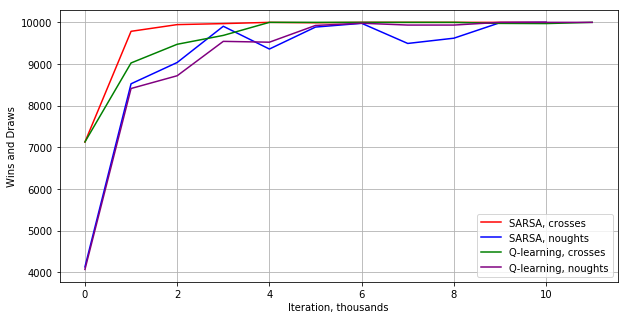

In [9]:
fig = plt.figure(figsize=(10, 5))

plt.plot(np.arange(historyS.shape[0]), historyS[:, 0], c='red', label='SARSA, crosses')
plt.plot(np.arange(historyS.shape[0]), historyS[:, 1], c='blue', label='SARSA, noughts')
plt.plot(np.arange(historyQ.shape[0]), historyQ[:, 0], c='green', label='Q-learning, crosses')
plt.plot(np.arange(historyQ.shape[0]), historyQ[:, 1], c='purple', label='Q-learning, noughts')

plt.xlabel('Iteration, thousands')
plt.ylabel('Wins and Draws')
plt.legend()
plt.grid()
plt.show()

In [10]:
mtch = Match()
hPlayer = humanPlayer()
crQ.playMode()
ntQ.playMode()

In [11]:
mtch.testSet(1, crQ, hPlayer, verbose=2)

o.x
.ox
xox

Crosses win



In [12]:
mtch.testSet(1, crQ, hPlayer, verbose=2)

oox
xoo
xxx

Crosses win



In [13]:
mtch.testSet(1, hPlayer, ntQ, verbose=2)

xox
oxx
oxo

Draw



In [14]:
mtch.testSet(1, hPlayer, ntQ, verbose=2)

xox
oox
xxo

Draw

